In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='whitegrid', palette='tab10')

In [3]:
#读取训练集和测试集
train = pd.read_csv("C:/Users/IrisWu/bike_sharing_demand/train.csv")
test = pd.read_csv("C:/Users/IrisWu/bike_sharing_demand/test.csv")
train_copy = train.copy()
test_copy = train.copy()

In [4]:
#合并训练集和测试集，用于检验两者分布是否一致
train_test = pd.concat([train,test],axis = 0)
train_test = train_test.sort_values(by='datetime').reset_index()
del train_test['index']

In [5]:
train

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


train：2011和2012年每个月前19天每个小时应该有10944个时间点，训练集中缺少了58个样本

In [6]:
test

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014
...,...,...,...,...,...,...,...,...,...
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981


test：2011和2012年每个月剩余天数每个小时应该有6600个时间点，测试集缺少了107个点

In [7]:
train_test

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
17374,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17375,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17376,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN
17377,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN


In [8]:
#查看无记录的时间点
#ts = pd.date_range('2011-01-01','2012-12-31',freq='H') #构造2011和2012年每个月每个小时的时间序列
#ts19 = ts[(ts.day>=1) & (ts.day <=19)] #构造2011和2012年每个月前19天每个小时的时间序列
#ts19= pd.DataFrame(ts19)
#ts19.columns =['datetime']
#train['datetime'] =pd.to_datetime(train['datetime'] )
#train = pd.merge(ts19,train,on='datetime',how='left')
#train[train.isnull().T.any()] #列出无记录的时间点

In [9]:
train_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    17379 non-null  object 
 1   season      17379 non-null  int64  
 2   holiday     17379 non-null  int64  
 3   workingday  17379 non-null  int64  
 4   weather     17379 non-null  int64  
 5   temp        17379 non-null  float64
 6   atemp       17379 non-null  float64
 7   humidity    17379 non-null  int64  
 8   windspeed   17379 non-null  float64
 9   casual      10886 non-null  float64
 10  registered  10886 non-null  float64
 11  count       10886 non-null  float64
dtypes: float64(6), int64(5), object(1)
memory usage: 1.6+ MB


train和test的特征都无空值

In [10]:
#train异常值检验
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [11]:
#test异常值检验
test.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
count,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000
mean,2.493300,0.029108,0.685815,1.436778,20.620607,24.012865,64.125212,12.631157
std,1.091258,0.168123,0.464226,0.648390,8.059583,8.782741,19.293391,8.250151
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,16.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,49.000000,7.001500
50%,3.000000,0.000000,1.000000,1.000000,21.320000,25.000000,65.000000,11.001400
75%,3.000000,0.000000,1.000000,2.000000,27.060000,31.060000,81.000000,16.997900
max,4.000000,1.000000,1.000000,4.000000,40.180000,50.000000,100.000000,55.998600


In [12]:
#检测count是否为casual和registered之和
train[(train['casual']+train['registered']!=train['count'])]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count


## 单变量分析

### casual，registered和count变量分布

[Text(0.5, 0, 'count'), Text(0.5, 1.0, 'Distribution of count')]

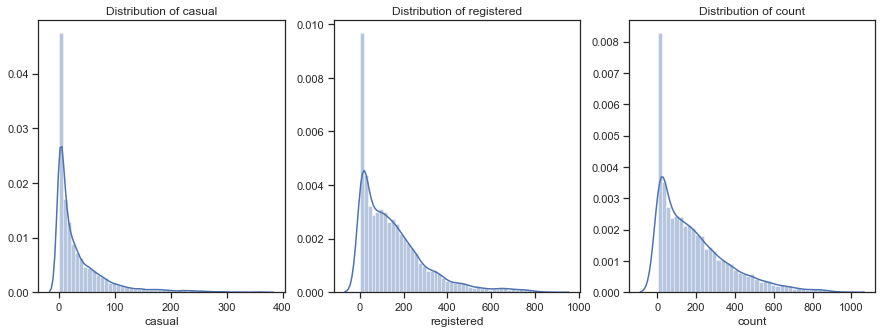

In [66]:
#观察总租用量密度分布情况
fig, axes = plt.subplots(1,3)
fig.set_size_inches(15, 5)
sns.distplot(train['casual'],ax=axes[0])
sns.distplot(train['registered'],ax=axes[1])
sns.distplot(train['count'],ax=axes[2])
axes[0].set(xlabel='casual', title='Distribution of casual')
axes[1].set(xlabel='registered', title='Distribution of registered')
axes[2].set(xlabel='count', title='Distribution of count')

可以发现数据分布偏斜比较严重，且有一个很长的尾巴，
可以排除掉距离均值3个标准差以为的数据或对数处理使得数据符合正态分布

In [67]:
#对casual,registered和count进行log变化
train['registered_log'] = np.log(train['registered'].values+1)
train['casual_log'] = np.log(train['casual'].values+1)
train['count_log'] = np.log(train['count'].values+1)

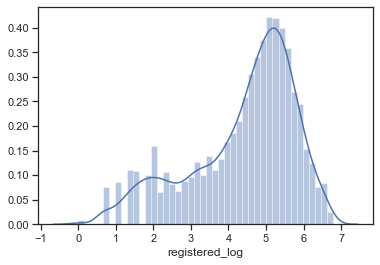

In [71]:
sns.distplot(train['registered_log'])

### 连续变量temp,atemp,humidity和windspeed分布

[Text(0.5, 0, 'Windspeed'),
 Text(0.5, 1.0, 'Distribution of windspeed of test')]

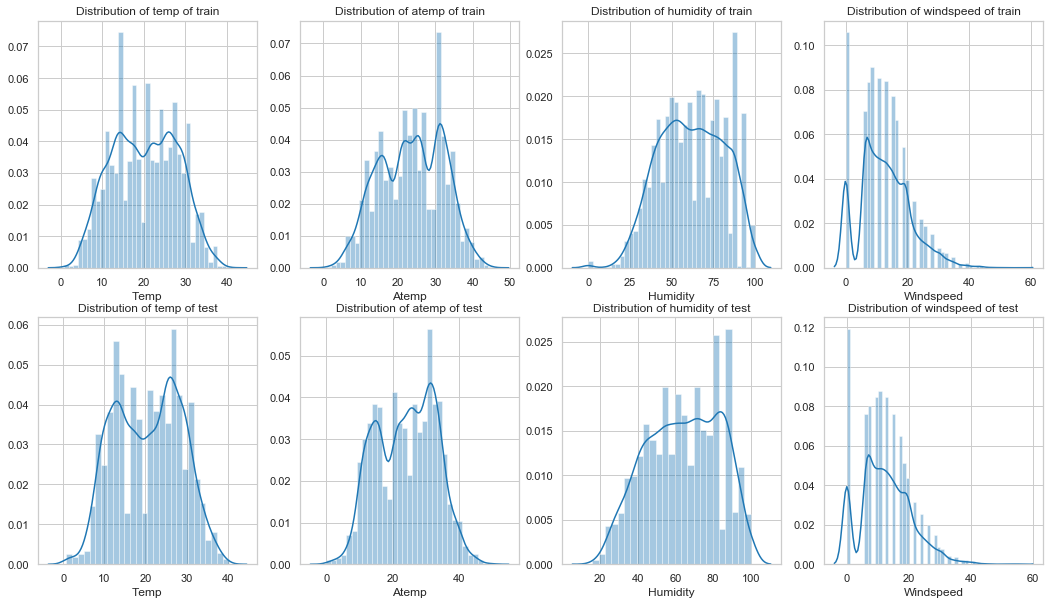

In [14]:
#查看train和test的temp,atemp,humidity和windspeed变量分布
fig, axes = plt.subplots(2,4)
fig.set_size_inches(18, 10)

sns.distplot(train['temp'], ax=axes[0,0])
sns.distplot(train['atemp'], ax=axes[0,1])
sns.distplot(train['humidity'], ax=axes[0,2])
sns.distplot(train['windspeed'], ax=axes[0,3])
sns.distplot(test['temp'], ax=axes[1,0])
sns.distplot(test['atemp'], ax=axes[1,1])
sns.distplot(test['humidity'], ax=axes[1,2])
sns.distplot(test['windspeed'], ax=axes[1,3])

axes[0,0].set(xlabel='Temp', title='Distribution of temp of train')
axes[0,1].set(xlabel='Atemp', title='Distribution of atemp of train')
axes[0,2].set(xlabel='Humidity', title='Distribution of humidity of train')
axes[0,3].set(xlabel='Windspeed', title='Distribution of windspeed of train')
axes[1,0].set(xlabel='Temp', title='Distribution of temp of test')
axes[1,1].set(xlabel='Atemp', title='Distribution of atemp of test')
axes[1,2].set(xlabel='Humidity', title='Distribution of humidity of test')
axes[1,3].set(xlabel='Windspeed', title='Distribution of windspeed of test')

从图中可看出：
1.train和test分布基本一致
2.temp,atemp以及humidity基本呈现正态分布
3.windspeed存在很多0值，应该为缺失值填充得来，需要进行缺失值处理

In [ ]:
#采用随机森林算法对windspeed的缺失值进行处理
from sklearn.ensemble import RandomForestRegressor
train_test['windspeed_rf']=train_test['windspeed']
#采用风速不等于0的数据做训练集，来预测风速为0的数据
windspeed_train = train_test[(train_test['windspeed_rf']!=0)]
windspeed_test = train_test[(train_test['windspeed_rf']==0)]
#根据相关系数分析，采用humidity,atemp,hour,month,year,day,weather特征来预测风速
rfr = RandomForestRegressor(n_estimators=1000, random_state=42)
feat = ['humidity','atemp','hour','month','year','day','weather']
rfr.fit(windspeed_train[feat], windspeed_train['windspeed_rf'])
windspeed_test['windspeed_rf'] = rfr.predict(X=windspeed_test[feat])
#连接两部分
train_test = windspeed_train .append(windspeed_test).reset_index()
del train_test['index']

[Text(0.5, 0, 'windspeed_rf'), Text(0.5, 1.0, 'Distribution of count')]

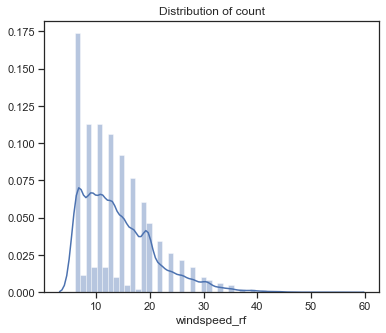

In [57]:
#查看填补缺失值后的windspeed分布
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
fig.set_size_inches(6,5)
sns.distplot(train_test['windspeed_rf'])
ax.set(xlabel='windspeed_rf', title='Distribution of count')

### 离散变量weather,holiday，workingday和季节分布情况

[Text(0.5, 0, 'season'), Text(0.5, 1.0, 'Distribution of season of test')]

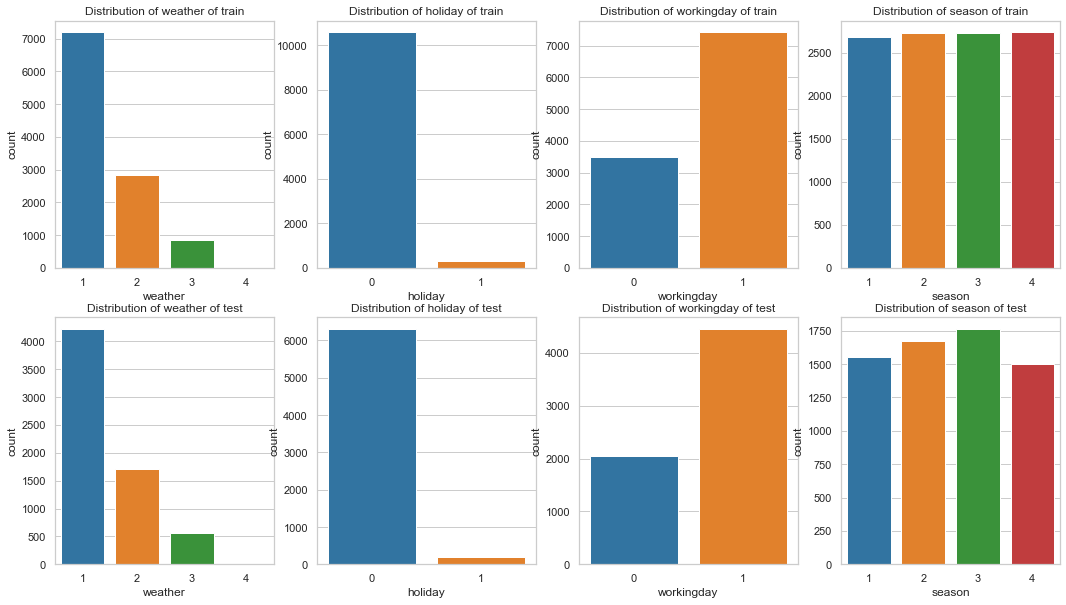

In [19]:
fig, axes = plt.subplots(2,4)
fig.set_size_inches(18, 10)

sns.countplot(train['weather'], ax=axes[0,0])
sns.countplot(train['holiday'], ax=axes[0,1])
sns.countplot(train['workingday'], ax=axes[0,2])
sns.countplot(train['season'], ax=axes[0,3])
sns.countplot(test['weather'], ax=axes[1,0])
sns.countplot(test['holiday'], ax=axes[1,1])
sns.countplot(test['workingday'], ax=axes[1,2])
sns.countplot(test['season'], ax=axes[1,3])

axes[0,0].set(xlabel='weather', title='Distribution of weather of train')
axes[0,1].set(xlabel='holiday', title='Distribution of holiday of train')
axes[0,2].set(xlabel='workingday', title='Distribution of workingday of train')
axes[0,3].set(xlabel='season', title='Distribution of season of train')
axes[1,0].set(xlabel='weather', title='Distribution of weather of test')
axes[1,1].set(xlabel='holiday', title='Distribution of holiday of test')
axes[1,2].set(xlabel='workingday', title='Distribution of workingday of test')
axes[1,3].set(xlabel='season', title='Distribution of season of test')

In [17]:
#查看train中weather=4的记录
train[(train['weather']==4)]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
5631,2012-01-09 18:00:00,1,0,1,4,8.2,11.365,86,6.0032,6,158,164


In [18]:
#查看test中weather=4的记录
test[(test['weather']==4)]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
154,2011-01-26 16:00:00,1,0,1,4,9.02,9.85,93,22.0028
3248,2012-01-21 01:00:00,1,0,0,4,5.74,6.82,86,12.9980


In [76]:
#查看train_test中holiday=1的记录
holiday = train_test[(train_test['holiday']==1)]['date'].drop_duplicates()

In [88]:
holiday

330      2011-01-17
1015     2011-02-21
2182     2011-04-15
3163     2011-05-30
3893     2011-07-04
5215     2011-09-05
5888     2011-10-10
6508     2011-11-11
6800     2011-11-24
7406     2011-12-26
7559     2012-01-02
7870     2012-01-16
8616     2012-02-20
9829     2012-04-16
10734    2012-05-28
11534    2012-07-04
12759    2012-09-03
13468    2012-10-08
14186    2012-11-12
14408    2012-11-22
15046    2012-12-25
Name: date, dtype: object

2011-01-01 & 2012-01-01 元旦
2011-01-17 & 2012-01-16 马丁路德金纪念日
2011-02-21 &2012-02-20 总统纪念日
2011-04-15 &2012-04-16 tax day  (不放假)
2011-05-30 &2012-05-28 阵亡将士纪念日
2011-07-04 &2012-07-04 美国独立纪念日
2011-09-05 &2012-09-03 劳动节
2011-10-10 &2012-10-08 哥伦布纪念日
2011-11-11 &2012-11-12 退伍军人节
2011-11-24 &2012-11-22 感恩节
2011-12-25 &2012-12-25 圣诞节(通常和元旦一起连休，因此2011-01-01到2011-01-06，2011-12-22到2012-01-06，2012-12-22-2012-12-31都对应假期)


In [ ]:
# tax day修改为非假日，工作日
train_test.loc[get_day(pd.datetime(2011, 4, 15)), "holiday"] = 0
train_test.loc[get_day(pd.datetime(2012, 4, 16)), "holiday"] = 0
train_test.loc[get_day(pd.datetime(2011, 4, 15)), "workingday"] = 1
train_test.loc[get_day(pd.datetime(2012, 4, 16)), "workingday"] = 1


# thanksgiving friday
df.loc[get_day(pd.datetime(2011, 11, 25)), "holiday"] = 1
df.loc[get_day(pd.datetime(2012, 11, 23)), "holiday"] = 1
df.loc[get_day(pd.datetime(2011, 11, 25)), "workingday"] = 0
df.loc[get_day(pd.datetime(2012, 11, 23)), "workingday"] = 0

#storms
df.loc[get_day(pd.datetime(2012, 5, 21)), "holiday"] = 1
df.loc[get_day(pd.datetime(2012, 5, 21)), "holiday"] = 1
#tornado
df.loc[get_day(pd.datetime(2012, 6, 1)), "holiday"] = 1

In [ ]:
datetime.strptime(time1str, '%Y-%m-%dT%H:%M:%S.%f')

In [105]:
train_test[(train_test['date']=="2011-04-16 00:00:00")]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,...,year,month,weekday,date,day,hour,windspeed_rf,registered_log,casual_log,count_log
10579,2012-05-21 00:00:00,2,0,1,3,23.78,27.275,88,19.9995,NaN,...,2012,5,0,2012-05-21,21,0,19.9995,NaN,NaN,NaN


从图中可看出：
训练集和测试集分布基本一致
weather中4对应的样本非常少，训练集中只有1个记录，测试集中有2个记录
holiday中1对应的样本很少
训练集中各季节数据均衡，测试集中夏季秋季样本相对更多

## 相关分析

### 分析目标变量casual，registered,count与时间相关特征的关系

In [27]:
#提取时间戳特征
train['year'] =pd.to_datetime(train['datetime']).dt.year
train['month'] =pd.to_datetime(train['datetime']).dt.month
train['weekday'] =pd.to_datetime(train['datetime']).dt.weekday
train['date'] = pd.to_datetime(train['datetime']).dt.date
train['day'] = pd.to_datetime(train['datetime']).dt.day
train['hour'] =pd.to_datetime(train['datetime']).dt.hour

test['year'] =pd.to_datetime(test['datetime']).dt.year
test['month'] =pd.to_datetime(test['datetime']).dt.month
test['weekday'] =pd.to_datetime(test['datetime']).dt.weekday
test['date'] = pd.to_datetime(test['datetime']).dt.date
test['day'] = pd.to_datetime(test['datetime']).dt.day
test['hour'] =pd.to_datetime(test['datetime']).dt.hour

train_test['year'] =pd.to_datetime(train_test['datetime']).dt.year
train_test['month'] =pd.to_datetime(train_test['datetime']).dt.month
train_test['weekday'] =pd.to_datetime(train_test['datetime']).dt.weekday
train_test['date'] = pd.to_datetime(train_test['datetime']).dt.date
train_test['day'] = pd.to_datetime(train_test['datetime']).dt.day
train_test['hour'] =pd.to_datetime(train_test['datetime']).dt.hour

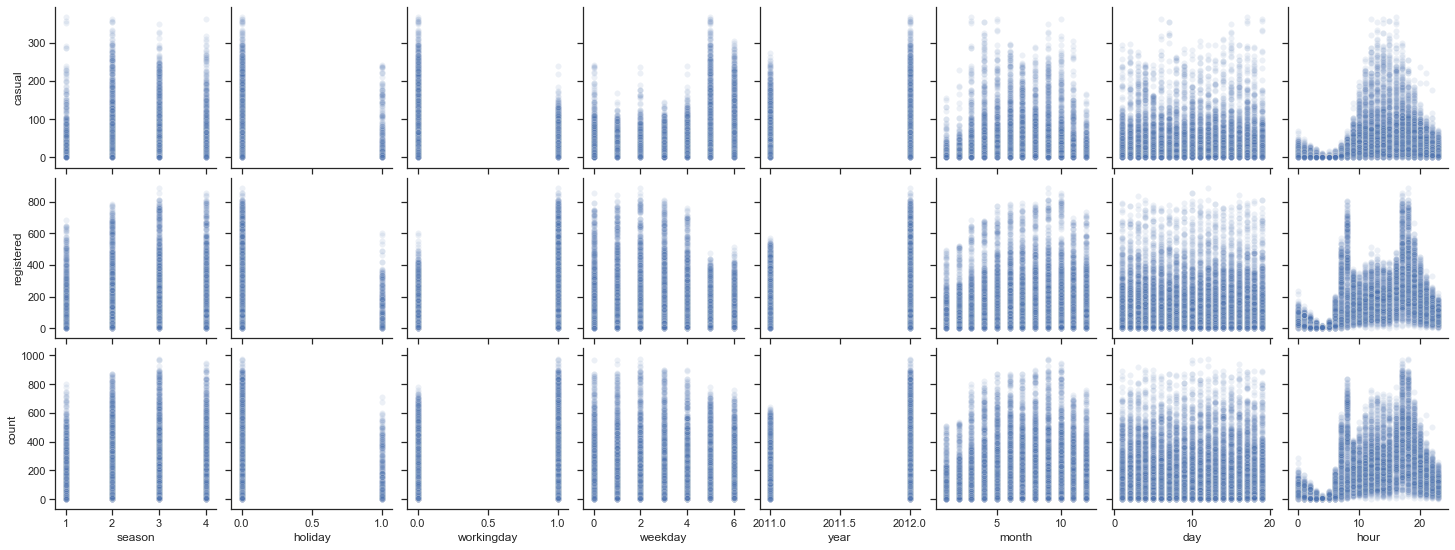

In [47]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(train, x_vars=['season','holiday','workingday','weekday','year','month', 'day','hour'],
             y_vars=['casual','registered','count'], plot_kws={'alpha':0.1})

### 分析目标变量casual，registered,count与天气相关特征的关系

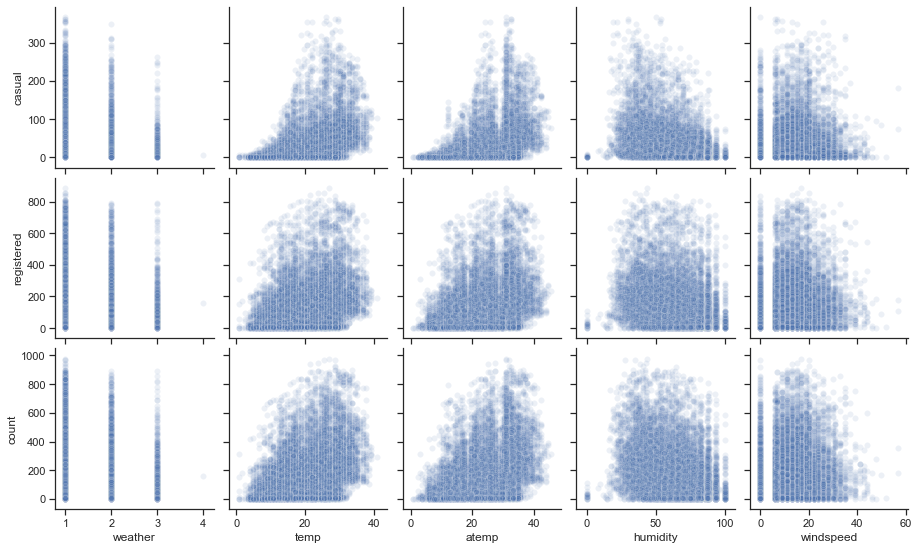

In [48]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(train, x_vars=['weather','temp','atemp', 'humidity','windspeed'],
             y_vars=['casual','registered','count'], plot_kws={'alpha':0.1})

从图中大致可以观察到：
1.一季度租用量总体偏少；
2.节假日租用量相比非节假日更少；
3.会员在工作日相比非工作日租用量多，临时用户则相反；周一到周五之间无明显区别。
4.2012年相比2011年租用量有明显上升趋势；
5.1月2月租用量相对最少，9月10月租用量相对最多；
6.日期之间租用量无明显区别；
7.会员呈现两个高峰(早八点和晚五点左右)，非会员呈现一个正态分布，凌晨时段(23：00-05：00)为低谷期；
8.天气情况越差，租用量越少；
9.0-10°以及40°左右时租用量明显减少，其次温度对会员影响较小，对非会员影响较大；
10.湿度较大时(代表降雨量)作用量明显减少，其次湿度对会员影响较小，对非会员影响较大；
11.风速超过20后租用量明显减少。

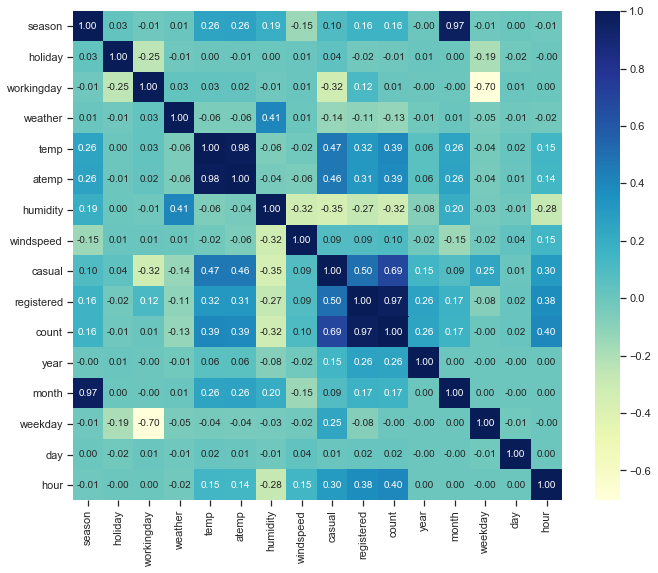

In [49]:
#计算相关系数
train_corr = train.corr()
fig = plt.figure()
ax = fig.add_subplot()
fig.set_size_inches(12,9)
sns.heatmap(train_corr, cbar=True, annot=True, square=True, \
                fmt='.2f', annot_kws={'size':10}, yticklabels=train_corr.columns.values, \
                xticklabels=train_corr.columns.values, cmap='YlGnBu',ax=ax)

从图中可得出:
1.temp和atemp几乎为线性关系，可删除atemp特征
2.season和month为线性关系，可删除季节特征
3.特征值对租赁数量的影响力度为,时段>温度>湿度(负相关)>年份>月份>季节>天气等级>风速>日期>是否工作日>是否假日

接下来首先查看温度、湿度、天气等级和风速的影响
然后查看时段、年份、月份、季度、日期以及是否工作日，是否假日的影响

### 温度中位数随时间(包括天/月/季度)的变化趋势以及各温度的平均租用量(包括casual,registered和count)

In [35]:
# 训练集
#按天取温度中位数
train_temp_date = train.groupby('date', as_index=False)['temp'].median()
train_temp_date['date']=pd.to_datetime(train_temp_date['date'])                                                                
#按月取温度中位数
train_temp_month = train.groupby(['year','month'], as_index=False)['temp'].median()
train_temp_month['year']=train_temp_month['year'].astype('string')
train_temp_month['month']=train_temp_month['month'].astype('string')
train_temp_month['date'] = train_temp_month.apply(lambda x:x['year']+'-'+x['month'],axis=1)
train_temp_month['date']=pd.to_datetime(train_temp_month['date'])
del train_temp_month['year']
del train_temp_month['month']
#按季节取温度中位数
train_temp_season = train.groupby(['year','season'], as_index=False)['temp'].median()
train_temp_season['season'] = [2,5,8,11,2,5,8,11]
train_temp_season['year']=train_temp_season['year'].astype('string')
train_temp_season['season']=train_temp_season['season'].astype('string')
train_temp_season['date'] = train_temp_season.apply(lambda x:x['year']+'-'+x['season'],axis=1)
train_temp_season['date']=pd.to_datetime(train_temp_season['date'])
del train_temp_season['year']
del train_temp_season['season']

In [37]:
# 测试集
#按天取温度中位数
test_temp_date = test.groupby('date', as_index=False)['temp'].median()
test_temp_date['date']=pd.to_datetime(test_temp_date['date'])                                                                
#按月取温度中位数
test_temp_month = test.groupby(['year','month'], as_index=False)['temp'].median()
test_temp_month['year']=test_temp_month['year'].astype('string')
test_temp_month['month']=test_temp_month['month'].astype('string')
test_temp_month['date'] = test_temp_month.apply(lambda x:x['year']+'-'+x['month'],axis=1)
test_temp_month['date']=pd.to_datetime(test_temp_month['date'])
del test_temp_month['year']
del test_temp_month['month']
#按季节取温度中位数
test_temp_season = test.groupby(['year','season'], as_index=False)['temp'].median()
test_temp_season['season'] = [2,5,8,11,2,5,8,11]
test_temp_season['year']=test_temp_season['year'].astype('string')
test_temp_season['season']=test_temp_season['season'].astype('string')
test_temp_season['date'] = test_temp_season.apply(lambda x:x['year']+'-'+x['season'],axis=1)
test_temp_season['date']=pd.to_datetime(test_temp_season['date'])
del test_temp_season['year']
del test_temp_season['season']

Text(0.5, 1.0, 'Change trend of average temperature of test')

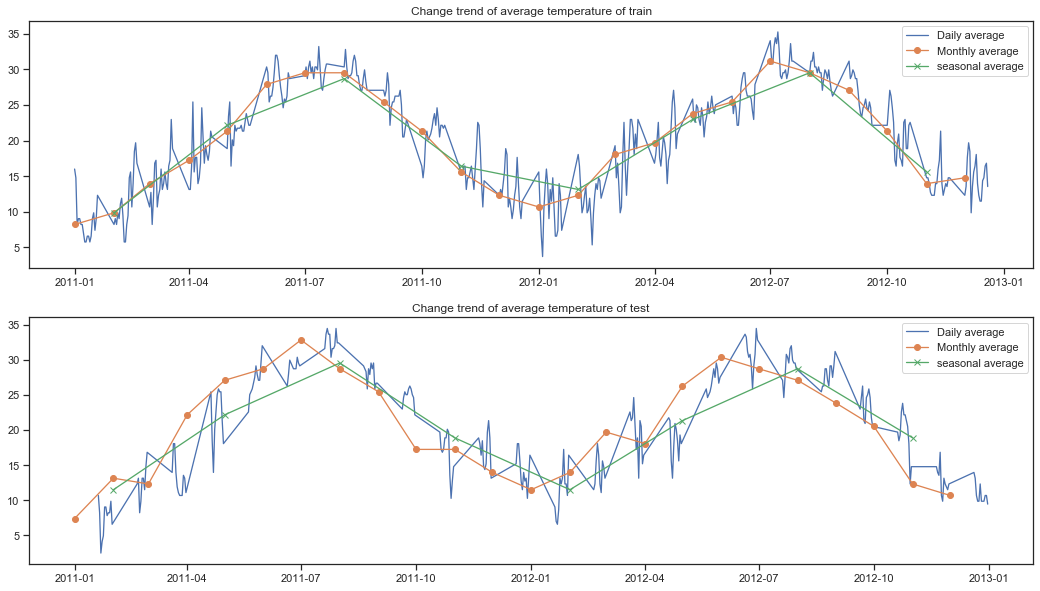

In [42]:
#使用折线图展示温度随时间的走势
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(2,1,1)
plt.plot(train_temp_date ['date'], train_temp_date ['temp'], linewidth=1.3, label='Daily average')
plt.plot(train_temp_month['date'],train_temp_month['temp'], marker='o', linewidth=1.3, label='Monthly average')
plt.plot(train_temp_season['date'],train_temp_season['temp'], marker='x', linewidth=1.3, label='seasonal average')
ax1.legend()
ax1.set_title(u'Change trend of average temperature of train')
ax2 = fig.add_subplot(2,1,2)
plt.plot(test_temp_date ['date'], test_temp_date ['temp'], linewidth=1.3, label='Daily average')
plt.plot(test_temp_month['date'],test_temp_month['temp'], marker='o', linewidth=1.3, label='Monthly average')
plt.plot(test_temp_season['date'],test_temp_season['temp'], marker='x', linewidth=1.3, label='seasonal average')
ax2.legend()
ax2.set_title(u'Change trend of average temperature of test')

从图中可以看出：
每年的气温随月份变化趋势相同，在7月份气温最高，1月份气温最低

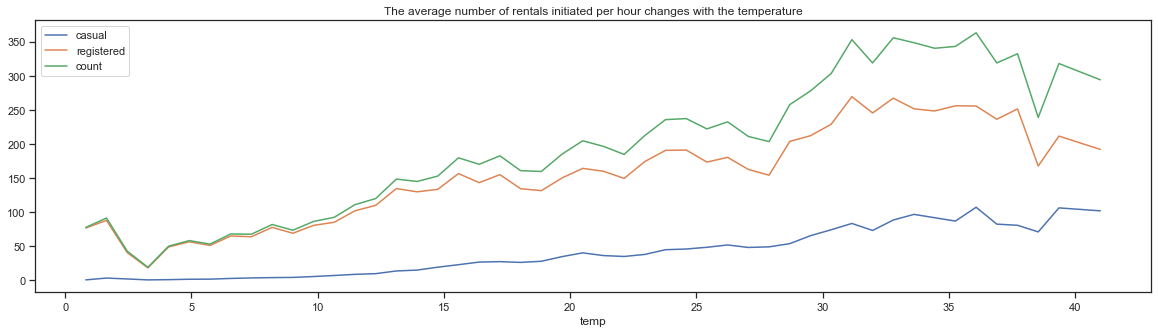

In [87]:
#按温度取租用量平均值
train_temp_count = train.groupby(['temp'], as_index=True)['casual','registered','count'].mean()
train_temp_count.plot(title = 'The average number of rentals initiated per hour changes with the temperature')

从图中可看出：
随气温上升租车数量总体呈现上升趋势，但在气温超过36时开始下降，在气温4度时达到最低点。

### 湿度平均数随时间(包括天/月/季度)的变化趋势以及各湿度的平均租用量(包括casual,registered和count)

In [43]:
#训练集
#按每天汇总湿度平均数
train_humidity_date = train.groupby('date', as_index=False)['humidity'].mean()
train_humidity_date['date']=pd.to_datetime(train_humidity_date['date'])                                                                        
#再按每年每月汇总取湿度平均数
train_humidity_month = train.groupby(['year','month'], as_index=False)['humidity'].mean()
train_humidity_month['year']=train_humidity_month['year'].astype('string')
train_humidity_month['month']=train_humidity_month['month'].astype('string')
train_humidity_month['date'] = train_humidity_month.apply(lambda x:x['year']+'-'+x['month'],axis=1)
train_humidity_month['date']=pd.to_datetime(train_humidity_month['date'])
del train_humidity_month['year']
del train_humidity_month['month']

#按季度取湿度平均数
train_humidity_season = train.groupby(['year','season'], as_index=False)['humidity'].mean()
train_humidity_season['season'] = [2,5,8,11,2,5,8,11] #将各季度日期分别设为2月，5月，8月，11月的1日
train_humidity_season['year']=train_humidity_season['year'].astype('string')
train_humidity_season['season']=train_humidity_season['season'].astype('string')
train_humidity_season['date'] = train_humidity_season.apply(lambda x:x['year']+'-'+x['season'],axis=1)
train_humidity_season['date']=pd.to_datetime(train_humidity_season['date'])
del train_humidity_season['year']
del train_humidity_season['season']

In [44]:
#测试集
#按每天汇总湿度平均数
test_humidity_date = test.groupby('date', as_index=False)['humidity'].mean()
test_humidity_date['date']=pd.to_datetime(test_humidity_date['date'])                                                                        
#再按每年每月汇总取湿度平均数
test_humidity_month = test.groupby(['year','month'], as_index=False)['humidity'].mean()
test_humidity_month['year']=test_humidity_month['year'].astype('string')
test_humidity_month['month']=test_humidity_month['month'].astype('string')
test_humidity_month['date'] = test_humidity_month.apply(lambda x:x['year']+'-'+x['month'],axis=1)
test_humidity_month['date']=pd.to_datetime(test_humidity_month['date'])
del test_humidity_month['year']
del test_humidity_month['month']

#按季度取湿度平均数
test_humidity_season = test.groupby(['year','season'], as_index=False)['humidity'].mean()
test_humidity_season['season'] = [2,5,8,11,2,5,8,11] #将各季度日期分别设为2月，5月，8月，11月的1日
test_humidity_season['year']=test_humidity_season['year'].astype('string')
test_humidity_season['season']=test_humidity_season['season'].astype('string')
test_humidity_season['date'] = test_humidity_season.apply(lambda x:x['year']+'-'+x['season'],axis=1)
test_humidity_season['date']=pd.to_datetime(test_humidity_season['date'])
del test_humidity_season['year']
del test_humidity_season['season']

Text(0.5, 1.0, 'Change trend of average humidity of test')

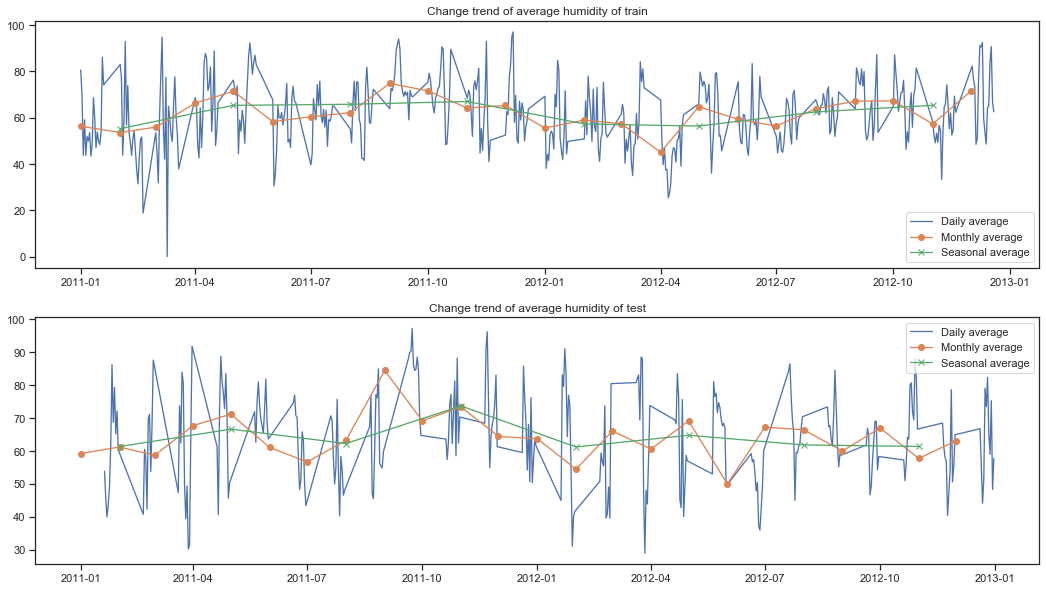

In [45]:
#使用折线图展示温度随时间的走势
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(2,1,1)
plt.plot(train_humidity_date['date'], train_humidity_date['humidity'], linewidth=1.3, label='Daily average')
plt.plot(train_humidity_month['date'],train_humidity_month['humidity'], marker='o', linewidth=1.3, label='Monthly average')
plt.plot(train_humidity_season['date'],train_humidity_season['humidity'], marker='x', linewidth=1.3, label='Seasonal average')
ax1.legend()
ax1.set_title(u'Change trend of average humidity of train')
ax2 = fig.add_subplot(2,1,2)
plt.plot(test_humidity_date['date'], test_humidity_date['humidity'], linewidth=1.3, label='Daily average')
plt.plot(test_humidity_month['date'],test_humidity_month['humidity'], marker='o', linewidth=1.3, label='Monthly average')
plt.plot(test_humidity_season['date'],test_humidity_season['humidity'], marker='x', linewidth=1.3, label='Seasonal average')
ax2.legend()
ax2.set_title(u'Change trend of average humidity of test')

每天的湿度波动较大，无明显规律；从月度来看在50-60上下波动；从季度来看在60上下波动
湿度存在0值，可能是缺失值

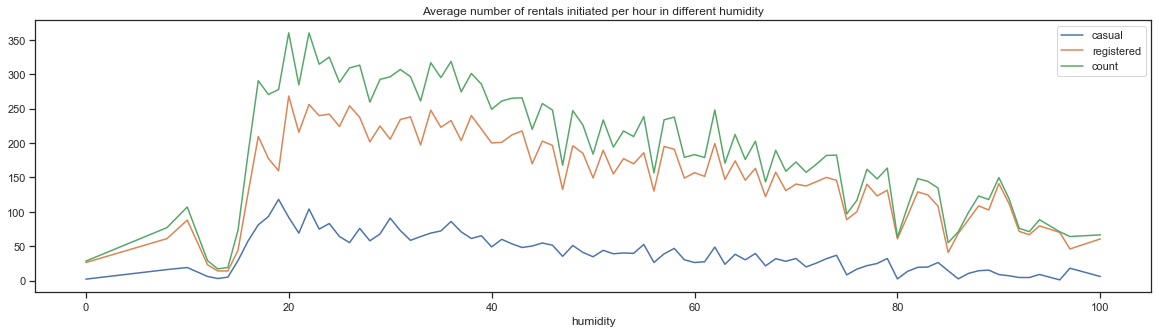

In [100]:
train_humidity_count = train.groupby(['humidity'], as_index=True)['casual','registered','count'].mean()
train_humidity_count.plot(title='Average number of rentals initiated per hour in different humidity')

从图中可看出：
湿度20左右租赁数量迅速达到高峰值，此后缓慢递减

### 各天气等级的平均租用量(包括casual,registered和count)

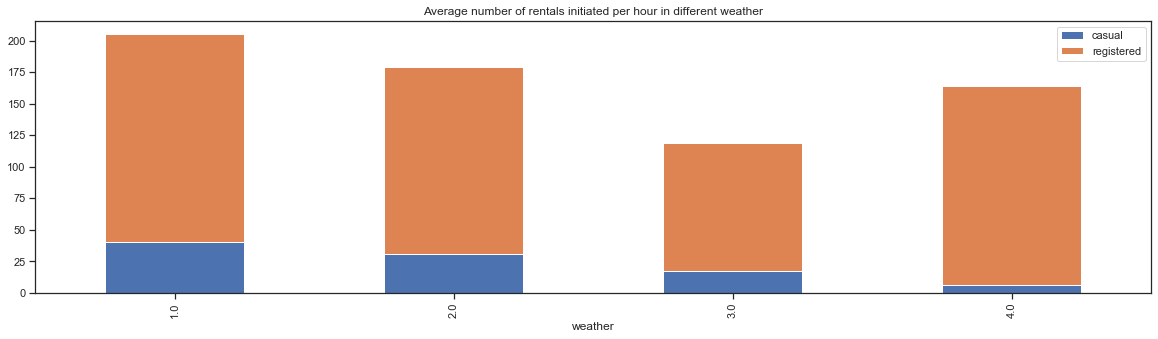

In [133]:
train_weather_count = train.groupby('weather', as_index=True)['casual','registered'].mean()
train_weather_count.plot.bar(stacked=True,title = 'Average number of rentals initiated per hour in different weather')

In [134]:
train[train['weather']==4]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,weekday,day,hour,date
5682,2012-01-09 18:00:00,1.0,0.0,1.0,4.0,8.2,11.365,86.0,6.0032,6.0,158.0,164.0,2012,1,0,9,18,2012-01-09


从图中可看出：
对于天气等级1-3，随着天气等级的提升而呈现下降趋势；
天气等级4的平均出行人数并不少，尤其是会员出行人数甚至比天气等级2的平均值还高，经查看发现天气等级4的数据只有一条，因为这条数据在下午六点的高峰期，可以认为是一个异常数据

### 风速平均数随时间(包括天/月/季度)的变化趋势以及各风速的平均租用量(包括casual,registered和count)

In [48]:
#训练集
#按天取风速平均数
train_windspeed_date = windspeed_train.groupby('date', as_index=False)['windspeed'].mean()
train_windspeed_date ['date']=pd.to_datetime(train_windspeed_date ['date'])                                                                        
#按月取风速平均数
train_windspeed_month = windspeed_train.groupby(['year','month'], as_index=False)['windspeed'].mean()
train_windspeed_month['year']=train_windspeed_month['year'].astype('string')
train_windspeed_month['month']=train_windspeed_month['month'].astype('string')
train_windspeed_month['date'] = train_windspeed_month.apply(lambda x:x['year']+'-'+x['month'],axis=1)
train_windspeed_month['date']=pd.to_datetime(train_windspeed_month['date'])
del train_windspeed_month['year']
del train_windspeed_month['month']
#按季度取风速平均数
train_windspeed_season = windspeed_train.groupby(['year','season'], as_index=False)['windspeed'].mean()
train_windspeed_season['season'] = [2,5,8,11,2,5,8,11] #将各季度日期分别设为2月，5月，8月，11月的1日
train_windspeed_season['year']=train_windspeed_season['year'].astype('string')
train_windspeed_season['season']=train_windspeed_season['season'].astype('string')
train_windspeed_season['date'] = train_windspeed_season.apply(lambda x:x['year']+'-'+x['season'],axis=1)
train_windspeed_season['date']=pd.to_datetime(train_windspeed_season['date'])
del train_windspeed_season['year']
del train_windspeed_season['season']

In [54]:
#测试集
#按天取风速平均数
test_windspeed_date = windspeed_test.groupby('date', as_index=False)['windspeed_rf'].mean()
test_windspeed_date ['date']=pd.to_datetime(test_windspeed_date ['date'])                                                                        
#按月取风速平均数
test_windspeed_month = windspeed_test.groupby(['year','month'], as_index=False)['windspeed_rf'].mean()
test_windspeed_month['year']=test_windspeed_month['year'].astype('string')
test_windspeed_month['month']=test_windspeed_month['month'].astype('string')
test_windspeed_month['date'] = test_windspeed_month.apply(lambda x:x['year']+'-'+x['month'],axis=1)
test_windspeed_month['date']=pd.to_datetime(test_windspeed_month['date'])
del test_windspeed_month['year']
del test_windspeed_month['month']
#按季度取风速平均数
test_windspeed_season = windspeed_test.groupby(['year','season'], as_index=False)['windspeed_rf'].mean()
test_windspeed_season['season'] = [2,5,8,11,2,5,8,11] #将各季度日期分别设为2月，5月，8月，11月的1日
test_windspeed_season['year']=test_windspeed_season['year'].astype('string')
test_windspeed_season['season']=test_windspeed_season['season'].astype('string')
test_windspeed_season['date'] = test_windspeed_season.apply(lambda x:x['year']+'-'+x['season'],axis=1)
test_windspeed_season['date']=pd.to_datetime(test_windspeed_season['date'])
del test_windspeed_season['year']
del test_windspeed_season['season']

Text(0.5, 1.0, 'Change trend of average windspeed of test')

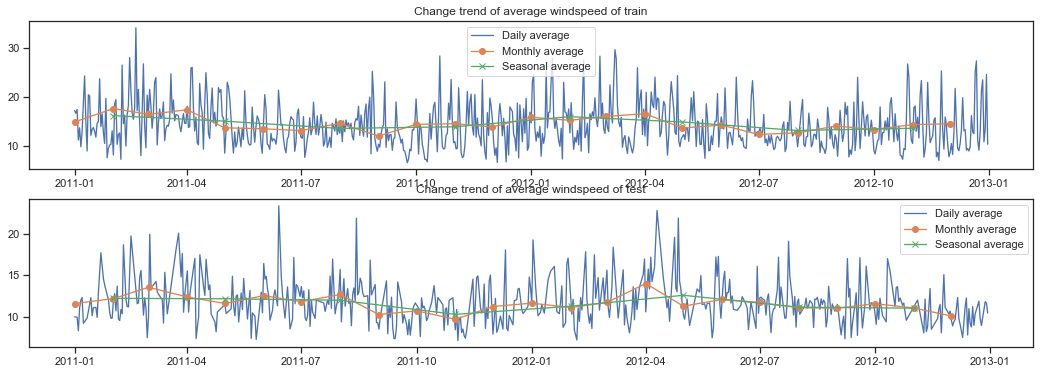

In [55]:
#使用折线图展示风速随时间的走势
fig = plt.figure(figsize=(18, 6))
ax1 = fig.add_subplot(2,1,1)
plt.plot(train_windspeed_date['date'], train_windspeed_date['windspeed'], linewidth=1.3, label='Daily average')
plt.plot(train_windspeed_month['date'],train_windspeed_month['windspeed'], marker='o', linewidth=1.3, label='Monthly average')
plt.plot(train_windspeed_season['date'],train_windspeed_season['windspeed'], marker='x', linewidth=1.3, label='Seasonal average')
ax1.legend()
ax1.set_title(u'Change trend of average windspeed of train')

ax2 = fig.add_subplot(2,1,2)
plt.plot(test_windspeed_date['date'], test_windspeed_date['windspeed_rf'], linewidth=1.3, label='Daily average')
plt.plot(test_windspeed_month['date'],test_windspeed_month['windspeed_rf'], marker='o', linewidth=1.3, label='Monthly average')
plt.plot(test_windspeed_season['date'],test_windspeed_season['windspeed_rf'], marker='x', linewidth=1.3, label='Seasonal average')
ax2.legend()
ax2.set_title(u'Change trend of average windspeed of test')

每天的风速波动较大，无明显规律；每月和每个季度的风速在10-15左右波动

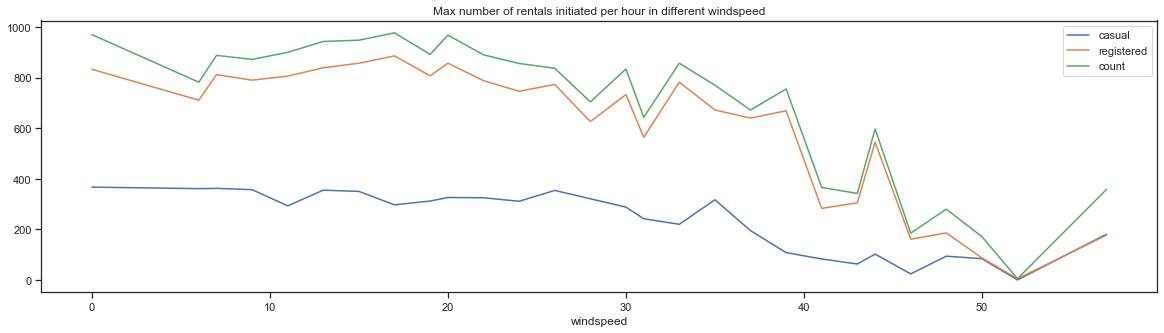

In [136]:
train_windspeed_count= train.groupby(['windspeed'], as_index=True)['casual','registered','count'].max()
train_windspeed_count.plot(title = 'Max number of rentals initiated per hour in different windspeed')

In [141]:
train[(train['windspeed'] >=37)&(train['count'] >=500)]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,weekday,day,hour,date
6569,2012-03-08 17:00:00,1.0,0.0,1.0,1.0,25.42,31.060,38.0,43.9989,52.0,545.0,597.0,2012,3,3,8,17,2012-03-08
8585,2012-07-16 17:00:00,3.0,0.0,1.0,3.0,31.16,36.365,66.0,39.0007,86.0,669.0,755.0,2012,7,0,16,17,2012-07-16
9811,2012-10-10 19:00:00,4.0,0.0,1.0,2.0,22.96,26.515,46.0,39.0007,32.0,534.0,566.0,2012,10,2,10,19,2012-10-10


In [142]:
train[(train['windspeed'] >45)&(train['count'] >=200)]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,weekday,day,hour,date
2801,2011-07-03 17:00:00,3.0,0.0,0.0,3.0,32.80,37.12,49.0,56.9969,181.0,177.0,358.0,2011,7,6,3,17,2011-07-03
7044,2012-04-09 12:00:00,2.0,0.0,1.0,1.0,22.14,25.76,28.0,47.9988,94.0,186.0,280.0,2012,4,0,9,12,2012-04-09


从图中可看出：
风速越大租赁数量越少，在风速超过30的时候明显减少，但风速在风速40和45左右却有一次反弹，应该是和天气情况一样存在异常的数据；
查看发现风速为39和44时，两次反弹，分别各1条记录，都是下午五点晚高峰时期；
风速为48时，有一个小反弹，对应的是中午12点；风速为57时，有一个较大的反弹，对应下午五点。

### 各时间维度(每天、每月和每个季度)平均租车量

In [130]:
#按天取平均租车量
train_count_date = train.groupby('date', as_index=False)['count'].mean()
train_count_date['date']=pd.to_datetime(train_count_date['date'])                                                                        
#按月取平均租车量
train_count_month = train.groupby(['year','month'], as_index=False)['count'].mean()
train_count_month['year']=train_count_month['year'].astype('string')
train_count_month['month']=train_count_month['month'].astype('string')
train_count_month['date'] = train_count_month.apply(lambda x:x['year']+'-'+x['month'],axis=1)
train_count_month['date']=pd.to_datetime(train_count_month['date'])
del train_count_month['year']
del train_count_month['month']
#按季度取平均租车量
train_count_season = train.groupby(['year','season'], as_index=False)['count'].mean()
train_count_season['season'] = [2,5,8,11,2,5,8,11] #将各季度日期分别设为2月，5月，8月，11月的1日
train_count_season['year']=train_count_season['year'].astype('string')
train_count_season['season']=train_count_season['season'].astype('string')
train_count_season['date'] = train_count_season.apply(lambda x:x['year']+'-'+x['season'],axis=1)
train_count_season['date']=pd.to_datetime(train_count_season['date'])
del train_count_season['year']
del train_count_season['season']

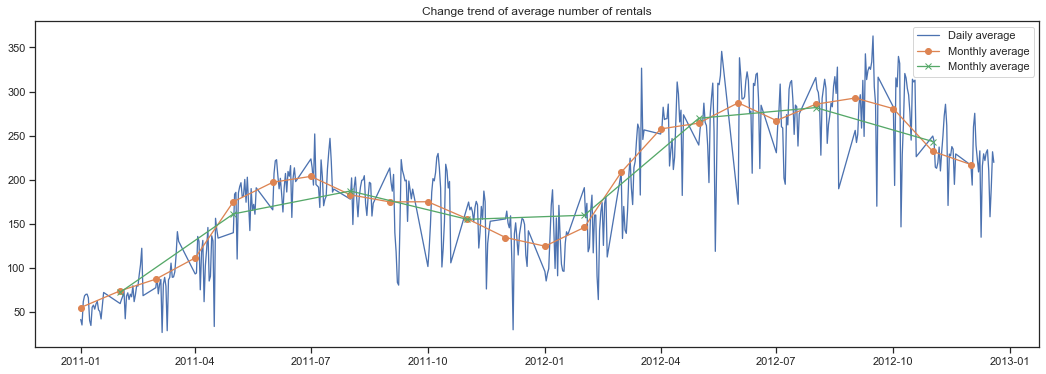

In [131]:
#使用折线图展示总体租赁情况（count）随时间的走势
fig = plt.figure(figsize=(18,6))
ax = fig.add_subplot(1,1,1)
plt.plot(train_count_date['date'] , train_count_date['count'] , linewidth=1.3 , label='Daily average')
plt.plot(train_count_month['date'] , train_count_month['count'] , marker='o',linewidth=1.3 , label='Monthly average')
plt.plot(train_count_season['date'] , train_count_season['count'] , marker='x',linewidth=1.3 , label='Monthly average')
ax.set_title('Change trend of average number of rentals')
ax.legend()

从图中可以看出：
共享单车的租赁情况2012年整体是比2011年有增涨的；
租赁情况随月份波动明显；
从夏季和秋季，租车量相比春季有大幅提升，秋季达到最高，冬季回落
数据在2011年9到12月，2012年3到9月间波动剧烈,有很多局部波谷值。

### workingday和holiday对应的平均租车量

In [ ]:
day_df = Bike_data.groupby(['date'], as_index=False).agg({'casual':'sum','registered':'sum',
                                                          'count':'sum', ')
number_pei = day_df[['casual', 'registered']].mean()
plt.axes(aspect='equal')
plt.pie(number_pei, labels=['casual', 'registered'], autopct='%1.1f%%',
       pctdistance=0.6, labeldistance=1.05, radius=1)
plt.title('Casual or registered in the total lease');       



workingday_df=day_df.groupby(['workingday'], as_index=True).agg({'casual':'mean', 'registered':'mean'})
workingday_df_0 = workingday_df.loc[0]
workingday_df_1 = workingday_df.loc[1]

# plt.axes(aspect='equal')
fig = plt.figure(figsize=(8,6)) 
plt.subplots_adjust(hspace=0.5, wspace=0.2)     #设置子图表间隔
grid = plt.GridSpec(2, 2, wspace=0.5, hspace=0.5)   #设置子图表坐标轴 对齐

plt.subplot2grid((2,2),(1,0), rowspan=2)
width = 0.3       # 设置条宽

p1 = plt.bar(workingday_df.index,workingday_df['casual'], width)
p2 = plt.bar(workingday_df.index,workingday_df['registered'], 
             width,bottom=workingday_df['casual'])
plt.title('Average number of rentals initiated per day')
plt.xticks([0,1], ('nonworking day', 'working day'),rotation=20)
plt.legend((p1[0], p2[0]), ('casual', 'registered'))

plt.subplot2grid((2,2),(0,0))
plt.pie(workingday_df_0, labels=['casual','registered'], autopct='%1.1f%%', 
        pctdistance=0.6 , labeldistance=1.35 , radius=1.3)
plt.axis('equal') 
plt.title('nonworking day')

plt.subplot2grid((2,2),(0,1))
plt.pie(workingday_df_1, labels=['casual','registered'], autopct='%1.1f%%', 
        pctdistance=0.6 , labeldistance=1.35 , radius=1.3)
plt.title('working day')
plt.axis('equal') 


holiday_df = day_df.groupby(['holiday'], as_index=True).agg({"casual":'mean','registered':'mean'})
holiday_df.plot.bar(stacked=True, title='Average umber of rentals initiated per day by holiday or not')


### 工作日和非工作日不同时段平均租车量的变化趋势

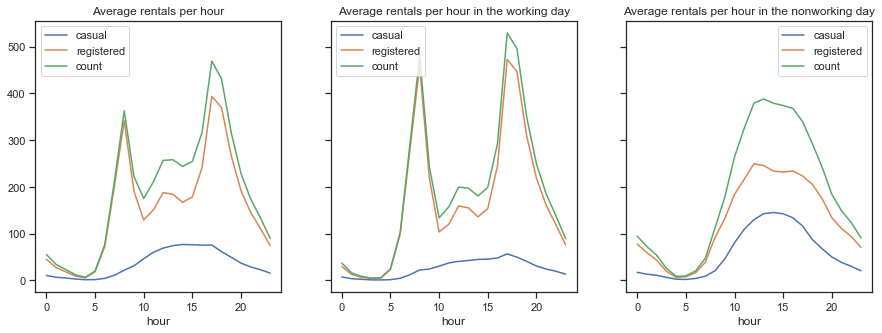

In [148]:
#工作日和非工作日不同时段平均租车量的变化趋势
train_hour = train.groupby(['hour'])['casual','registered','count',].mean()
train_working = train[train['workingday'] == 1].groupby(['hour'])['casual','registered','count',].mean()
train_unworking = train[train['workingday'] == 0].groupby(['hour'])['casual','registered','count',].mean()
fig, axes = plt.subplots(1, 3, sharey=True)
train_hour.plot(figsize=(15,5),title='Average rentals per hour',ax=axes[0])
train_working.plot(figsize=(15,5),title='Average rentals per hour in the working day',ax=axes[1])
train_unworking.plot(figsize=(15,5), title='Average rentals per hour in the nonworking day',ax=axes[2])   

从图中可看出：
1.工作日：会员用户上下班时间是两个用车高峰，而中午也会有一个小高峰，猜测可能是外出午餐的人；
而对临时用户起伏比较平缓，高峰期在17点左右；并且会员用户的用车数量远超过临时用户。
2.非工作日：会员和非会员用户趋势一致，租车量随时间呈现一个正态分布，高峰在14点左右，低谷在凌晨4点左右，且分布比较均匀。

In [52]:
count_per_year= train[['year','count','registered']].groupby('year').mean().reset_index()
count_per_year['rcount_rate_per_year'] = count_per_year['registered']/count_per_year['count']
count_per_season= train[['season','count','registered']].groupby('season').mean().reset_index()
count_per_season['rcount_rate_per_season'] = count_per_season['registered']/count_per_season['count']
count_per_month = train[['month','count','registered']].groupby('month').mean().reset_index()
count_per_month ['rcount_rate_per_month'] = count_per_month ['registered']/count_per_month ['count']
count_per_weekday= train[['weekday','count','registered']].groupby('weekday').mean().reset_index()
count_per_weekday['rcount_rate_per_weekday'] = count_per_weekday['registered']/count_per_weekday['count']
count_per_day= train[['date','count','registered']].groupby('date').mean().reset_index()
count_per_day['rcount_rate_per_day'] = count_per_day['registered']/count_per_day['count']
count_per_hour= train[['hour','count','registered']].groupby('hour').mean().reset_index()
count_per_hour['rcount_rate_per_hour'] = count_per_hour['registered']/count_per_hour['count']

In [74]:
count_per_hour_season= train[['season','hour','count']].groupby(['season','hour']).mean().reset_index()

In [78]:
count_per_hour_season.pivot(index='season')

TypeError: pivot() missing 1 required argument: 'columns'

In [79]:
plt.figure()
count_per_hour_season.plot(x='hour',y=)

SyntaxError: invalid syntax (<ipython-input-79-cec253e0640f>, line 2)

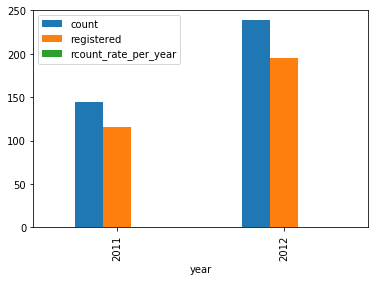

In [62]:
count_per_year.set_index('year').plot(kind='bar')

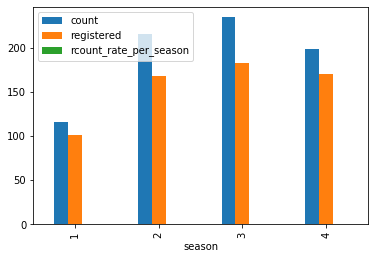

In [61]:
count_per_season.set_index('season').plot(kind='bar')

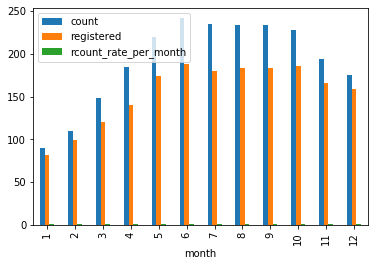

In [63]:
count_per_month.set_index('month').plot(kind='bar')

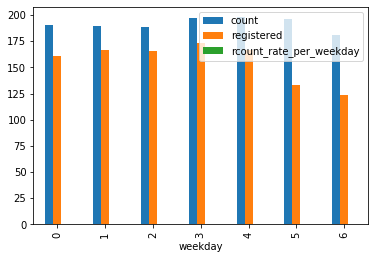

In [64]:
count_per_weekday.set_index('weekday').plot(kind='bar')